In [ ]:
# ====== 1. Import Libraries ======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# ====== 2. Data Loading & Preparation Functions ======
def load_and_prepare_data(filepath):
    """Load and preprocess solar data"""
    df = pd.read_csv(filepath, parse_dates=['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)

    # Feature engineering
    df['TEMP_DIFF'] = df['MODULE_TEMPERATURE'] - df['AMBIENT_TEMPERATURE']
    df['HOUR'] = df.index.hour
    df['DAY_OF_WEEK'] = df.index.dayofweek

    return df

def select_features_target(df, target='AC_POWER'):
    """Select features and target variable"""
    features = [
        'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
        'IRRADIATION', 'HOUR', 'TEMP_DIFF'
    ]

    X = df[features]
    y = df[target]

    return X, y

def temporal_train_test_split(X, y, test_size=0.2):
    """Temporal split maintaining time order"""
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test



In [ ]:
# ====== 3. Model Building Functions ======
def train_arima(y_train, y_test, order=(1,1,1)):
    """Train and evaluate ARIMA model"""
    model = ARIMA(y_train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(y_test))
    return predictions

def train_svm(X_train, y_train, X_test):
    """Train and evaluate SVM model"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='rbf', C=100, gamma=0.1)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    return predictions, scaler

def create_lstm_data(X, y, timesteps=6):
    """Create time-series sequences for LSTM"""
    X_seq, y_seq = [], []

    for i in range(timesteps, len(X)):
        X_seq.append(X.iloc[i-timesteps:i])
        y_seq.append(y.iloc[i])

    return np.array(X_seq), np.array(y_seq)

def build_lstm_model(input_shape):
    """Construct LSTM model architecture"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )


    return model

In [ ]:
# ====== 4. Evaluation Functions ======
def evaluate_model(name, y_true, y_pred):
    """Calculate and print evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Calculate percentage errors relative to mean
    mean_val = np.mean(y_true)
    mae_pct = (mae / mean_val) * 100
    rmse_pct = (rmse / mean_val) * 100

    print(f"\n{name} Performance:")
    print(f"- MAE: {mae:.2f} kW ({mae_pct:.1f}%)")
    print(f"- RMSE: {rmse:.2f} kW ({rmse_pct:.1f}%)")
    print(f"- R²: {r2:.4f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAE_pct': mae_pct, 'RMSE_pct': rmse_pct}

def plot_predictions(y_true, y_pred, title, n_points=200):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:n_points], label='Actual', alpha=0.8, linewidth=2)
    plt.plot(y_pred[:n_points], label='Predicted', linestyle='--')
    plt.title(title, fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('AC Power (kW)', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()



Training ARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Training SVM model...

Preparing LSTM data...

Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 131288472.0000 - mean_absolute_error: 7160.8286 - val_loss: 115495192.0000 - val_mean_absolute_error: 6528.4404
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 121477576.0000 - mean_absolute_error: 6730.2573 - val_loss: 115290856.0000 - val_mean_absolute_error: 6524.8530
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119691320.0000 - mean_absolute_error: 6599.6455 - val_loss: 115055944.0000 - val_mean_absolute_error: 6530.3340
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 124066800.0000 - mean_absolute_error: 6950.0542 - val_loss: 114769936.0000 - val_mean_absolute_error: 6529.1973
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 121674808.0000 - mean_absolute_error: 6872.0693 - val_loss: 114427232.0000 - val_mean_absolute_error: 6527.7109
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 122281352.0000 - mean_absolute_error: 6734.5898 - val_loss: 1

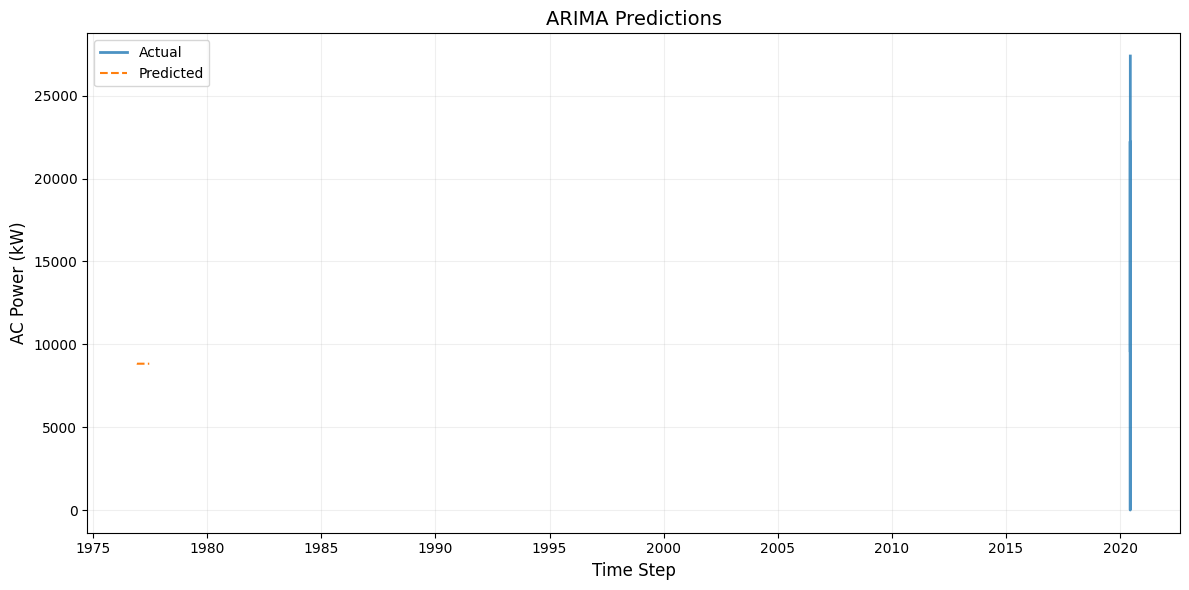

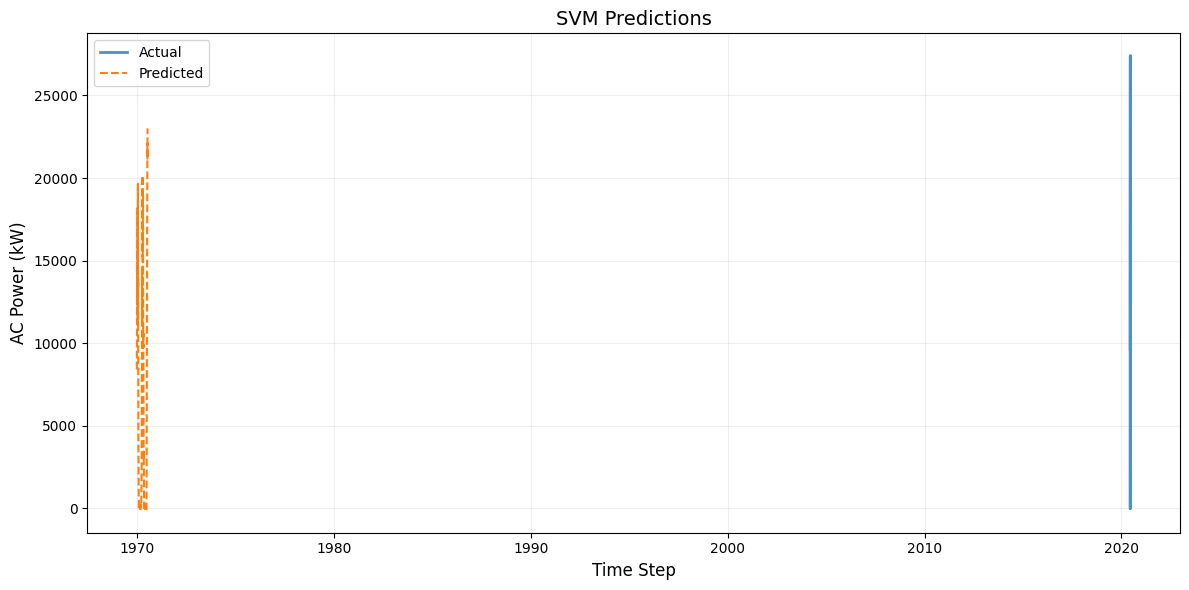

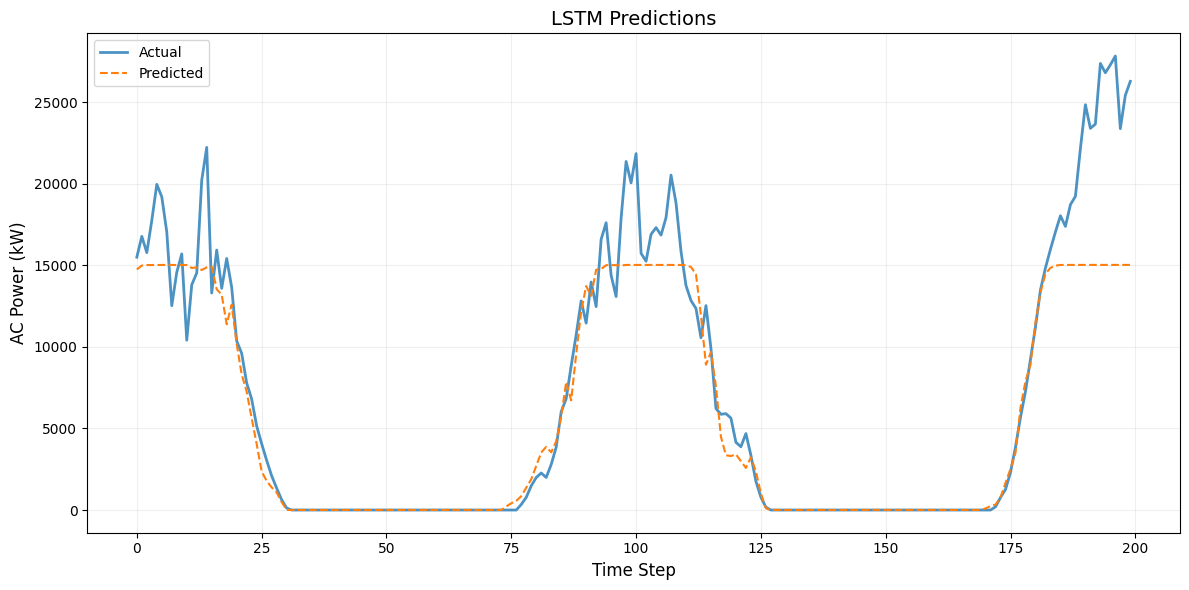

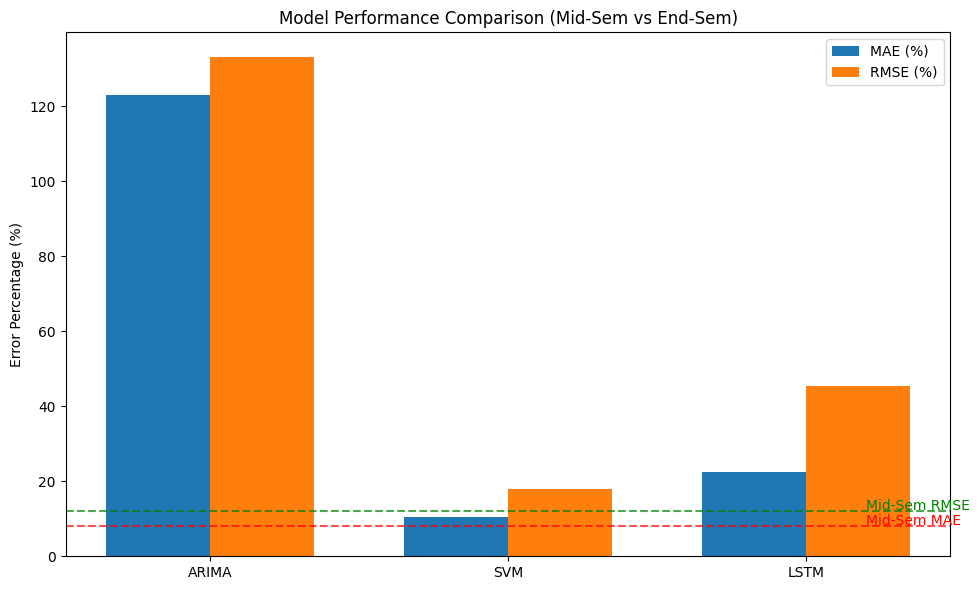


LSTM model saved as 'solar_lstm_model.h5'


In [ ]:
# ====== 5. Main Execution ======
def main():
    # Load and prepare data
    solar_df = load_and_prepare_data('/content/Preprocessed_SolarPlant_Data.csv')
    X, y = select_features_target(solar_df, target='AC_POWER')

    # Temporal train-test split
    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)

    # Train baseline models
    print("Training ARIMA model...")
    arima_pred = train_arima(y_train, y_test)

    print("\nTraining SVM model...")
    svm_pred, scaler = train_svm(X_train, y_train, X_test)

    # Prepare LSTM data
    print("\nPreparing LSTM data...")
    timesteps = 6
    X_train_seq, y_train_seq = create_lstm_data(X_train, y_train, timesteps)
    X_test_seq, y_test_seq = create_lstm_data(X_test, y_test, timesteps)

    # Scale data for LSTM
    lstm_scaler = StandardScaler()
    X_train_scaled = lstm_scaler.fit_transform(
        X_train_seq.reshape(-1, X_train_seq.shape[2])
    ).reshape(X_train_seq.shape)

    X_test_scaled = lstm_scaler.transform(
        X_test_seq.reshape(-1, X_test_seq.shape[2])
    ).reshape(X_test_seq.shape)

    # Build and train LSTM
    print("\nBuilding LSTM model...")
    lstm_model = build_lstm_model((timesteps, X_train.shape[1]))

    print("\nTraining LSTM model...")
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = lstm_model.fit(
        X_train_scaled, y_train_seq,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    # Make predictions
    lstm_pred = lstm_model.predict(X_test_scaled).flatten()

    # Evaluate models
    results = {}
    results['ARIMA'] = evaluate_model("ARIMA", y_test, arima_pred)
    results['SVM'] = evaluate_model("SVM", y_test, svm_pred)
    results['LSTM'] = evaluate_model("LSTM", y_test_seq, lstm_pred)

    # Visualize results
    plot_predictions(y_test, arima_pred, "ARIMA Predictions")
    plot_predictions(y_test, svm_pred, "SVM Predictions")
    plot_predictions(y_test_seq, lstm_pred, "LSTM Predictions")

    # Plot model comparison
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    mae_values = [results[m]['MAE_pct'] for m in models]
    rmse_values = [results[m]['RMSE_pct'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, mae_values, width, label='MAE (%)')
    plt.bar(x + width/2, rmse_values, width, label='RMSE (%)')

    # Add improvement annotations
    mid_sem = [8.2, 12.1]  # Mid-semester MAE%, RMSE%
    plt.axhline(y=mid_sem[0], color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=mid_sem[1], color='g', linestyle='--', alpha=0.7)
    plt.text(2.2, mid_sem[0]+0.2, 'Mid-Sem MAE', color='r')
    plt.text(2.2, mid_sem[1]+0.2, 'Mid-Sem RMSE', color='g')

    plt.xticks(x, models)
    plt.ylabel('Error Percentage (%)')
    plt.title('Model Performance Comparison (Mid-Sem vs End-Sem)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Save final model
    lstm_model.save('solar_lstm_model.h5')
    print("\nLSTM model saved as 'solar_lstm_model.h5'")

    # Also save the scaler
    import joblib
    joblib.dump(lstm_scaler, 'lstm_scaler.pkl')


if __name__ == "__main__":
    main()